In [101]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

from matplotlib import pyplot as plt
%matplotlib inline

<ipython-input-101-83b25963ad00>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [102]:
!ls ../../data

2017-01-01_2021-10-31_ethereumprice_org.csv
cora_edges.csv
cora_nodes.csv
edges.csv
edges_withTotalPriceUSD.csv
nodes.csv


In [103]:
node_df = pd.read_csv("../../data/nodes.csv")
print(len(node_df))

5123


In [104]:
edge_df = pd.read_csv("../../data/edges.csv")
edge_df['month'] = edge_df['Timestamp'].str[:7]
edge_df['date'] = edge_df['Timestamp'].str[:10]
edge_df['Timestamp'] = pd.to_datetime(edge_df['Timestamp'])
edge_df['TotalPrice'] = edge_df['TotalPrice'].astype("float")/(10**18)


# Fixing the column names (Seller and Winner columns are switched in this version of data)
edge_df = edge_df.rename(columns = {'SellerAddress': 'WinnerAddress', 'WinnerAddress': 'SellerAddress'})
print(edge_df.shape)

(175428, 18)


##### Check if 0x0000 address exists

In [105]:
check_zeroAddr = edge_df.fillna('')
len(check_zeroAddr[check_zeroAddr['SellerAddress'].str.contains('0x000000000000000')])

0

##### Check duplicates

In [106]:
print("Count after dropping duplicates:", len(edge_df.drop_duplicates()))
print("Complete duplicate counts:", len(edge_df) - len(edge_df.drop_duplicates()))

Count after dropping duplicates: 175243
Complete duplicate counts: 185


In [107]:
# Dropping duplicates
edge_df = edge_df.drop_duplicates()

##### Check the number of wallet addresses in the edge data

In [108]:
sellerAddr = edge_df['SellerAddress'].dropna().drop_duplicates().values.flatten()
winnerAddr = edge_df['WinnerAddress'].dropna().drop_duplicates().values.flatten()
bidderAddr = edge_df['FromAccountAddress'].dropna().drop_duplicates().values.flatten()

print("Unique wallet address count in SellerAddress:", len(sellerAddr))
print("Unique wallet address count in WinnerAddress:", len(winnerAddr))
print("Unique wallet address count in FromAccountAddress:", len(bidderAddr))
print("Unique wallet addresses in all:", len(set(sellerAddr.tolist() + winnerAddr.tolist() + bidderAddr.tolist())))

Unique wallet address count in SellerAddress: 2814
Unique wallet address count in WinnerAddress: 4502
Unique wallet address count in FromAccountAddress: 5395
Unique wallet addresses in all: 7495


In [109]:
# Re-creating the node_df
node_df = pd.DataFrame(set(sellerAddr.tolist() + winnerAddr.tolist() + bidderAddr.tolist()), columns = ['node_id'])
len(node_df)

7495

# Ethereum price

** CAVEAT. 9/4/2021 price is missing Used ETH price of 9/3/2021 for that date **

In [123]:
eth_df = pd.read_csv("../../data/2017-01-01_2021-10-31_ethereumprice_org.csv")

In [124]:
eth_df.head()

,timestamp,open,high,low,close
0,1635638400,4328.810000,4395.1,4176.37,4288.647863307195
1,1635638340,4325.869542,undefined,undefined,undefined
2,1635552000,4426.660000,4427.491984588295,4251.859043408258,4319.030758213976
3,1635551940,4415.685773,undefined,undefined,undefined
4,1635465600,4287.945607,4460.505640780439,4271.599874791511,4415.427223930739


In [125]:
eth_df = eth_df[eth_df['open'] != 'undefined']
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'], unit='s')
eth_df['date_str'] = eth_df['timestamp'].apply(lambda dt: str(dt)[:10])
eth_df['time_str'] = eth_df['timestamp'].apply(lambda dt: str(dt)[-8:])
eth_df = eth_df[eth_df['time_str'] == "00:00:00"]
eth_df = eth_df[['date_str', 'open']].set_index('date_str')
eth_df.columns = ["eth_open_price"]

In [126]:
eth_df = eth_df.append(pd.DataFrame([3787.989114], index=['2021-09-04'], columns=['eth_open_price']))

In [114]:
eth_df = eth_df.set_index(pd.to_datetime(eth_df.index))

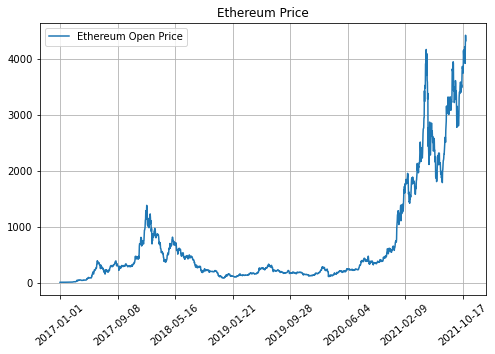

In [121]:
# ax = eth_df.plot(grid=True, figsize=(12, 6), rot=40, title="Ethereum Price")
# x_labels = eth_df.index.strftime('%y %b')
# ax.set_xticklabels(x_labels)


eth_df.sort_index().plot(grid=True, figsize=(8, 5), rot=40, title="Ethereum Price")


In [127]:
edge_df = edge_df.join(eth_df, on='date')
edge_df['TotalPriceUSD'] = edge_df['TotalPrice'] * edge_df['eth_open_price']

In [128]:
edge_df.columns

Index(['WinnerAddress', 'SellerAddress', 'Timestamp', 'EventType',
       'PaymenTokenSymbol', 'TotalPrice', 'TokenId', 'AssetContractAddress',
       'AssetId', 'TransactionId', 'BidAmount', 'AssetNumSales',
       'AssetOwnerAddress', 'FromAccountAddress', 'UsedEthscan',
       'TransactionHash', 'month', 'date', 'Ethereum Open Price',
       'eth_open_price', 'TotalPriceUSD'],
      dtype='object')

In [129]:
temp_df = edge_df.dropna(subset=['SellerAddress', 'WinnerAddress']).reset_index()
temp_df = temp_df.fillna("")
temp_df.columns = ['index', 'source', 'target', 'Timestamp', 'EventType',
       'PaymenTokenSymbol', 'TotalPrice', 'TokenId', 'AssetContractAddress',
       'AssetId', 'TransactionId', 'BidAmount', 'AssetNumSales',
       'AssetOwnerAddress', 'FromAccountAddress', 'UsedEthscan',
       'TransactionHash', 'mouth', 'date', 'eth_open_price', 'TotalPriceUSD']
json_format['links'] = temp_df.to_dict("records")

import json
with open('flask_app/flaskr/static/opensea_oct29.json', 'w') as outfile:
    json.dump(json_format, outfile)

ValueError: Length mismatch: Expected axis has 22 elements, new values have 21 elements

# Exploration starts

In [130]:
print("Count of event types")
edge_df['EventType'].value_counts()

Count of event types


created          65631
cancelled        26856
bid_entered      26796
transfer         22301
successful       17358
bid_withdrawn    16301
Name: EventType, dtype: int64

In [131]:
eth_df

,eth_open_price
2021-10-31,4328.810000
2021-10-30,4426.660000
2021-10-29,4287.945607
2021-10-28,3923.735710
2021-10-27,4131.247954
...,...
2017-01-04,10.880000
2017-01-03,9.590000
2017-01-02,8.330000
2017-01-01,8.140000


In [132]:
edge_df[edge_df['TokenId'] == 3100]

,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,...,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,Ethereum Open Price,eth_open_price,TotalPriceUSD
126795,NaN,NaN,2021-09-14 22:47:08,bid_withdrawn,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,164374831.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x319aae1e01c1bfcd106c1063cd230a59375368f5,False,0x4724c3c2f089b0eb93e55861bc1e0922e488bd3f464bcc0dd9168c4c5a5eda3d,2021-09,2021-09-14,3280.730000,3280.730000,NaN
126796,NaN,NaN,2021-09-14 11:42:33,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,164099462.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x319aae1e01c1bfcd106c1063cd230a59375368f5,False,0xaa7270b3b1a9bd08cbb0a98eae87b751bfc42ed4eee8644f8372aa26a6cab4c9,2021-09,2021-09-14,3280.730000,3280.730000,NaN
126797,NaN,NaN,2021-08-30 16:00:57,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,156184223.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0x151d89bc14c443d1d3f15465b6be32d443a4f1d8eeb15a044ac2e491fbb88e46,2021-08,2021-08-30,3228.658734,3228.658734,NaN
126798,NaN,NaN,2021-08-28 17:16:36,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,155086705.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0xfe2f0ada3cb1f1aae2d59e7ce78f918a21b4c1c09f25a1984ae87d1094fb9631,2021-08,2021-08-28,3270.666681,3270.666681,NaN
126799,NaN,NaN,2021-08-08 11:16:10,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,145701532.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0xeea014dfe7e902f3848794752de691e1cc583edb,False,0x7460ff1bb67f685d61da7ab168cd133fc588e62b3caa32c528f99c2ba93e99bc,2021-08,2021-08-08,3158.300000,3158.300000,NaN
126800,NaN,NaN,2021-08-01 12:28:41,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,142933217.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0x89a0295dc4a1f9fd314585ef19850890939bcb3630434e714c1eefb49943b28d,2021-08,2021-08-01,2524.010000,2524.010000,NaN
126801,NaN,NaN,2021-07-05 10:44:27,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,132847310.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x72fae93d08a060a7f0a8919708c0db74ca46cbb6,False,0x65a84875272bd1610a5eb73dfeefcb180bc98ee5877600b96e8b05df0c6f3858,2021-07,2021-07-05,2317.360000,2317.360000,NaN
126802,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x6611fe71c233e4e7510b2795c242c9a57790b376,2021-03-11 20:57:01,successful,ETH,4200.0,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314752.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,True,0xa1c6097dedb55e7ba1a1d015be6ec2132cf2f75d636d753c2f21029e7cee4ce7,2021-03,2021-03-11,1778.040000,1778.040000,7467768.0
126803,NaN,NaN,2021-03-11 20:54:14,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314182.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,False,0xd46d6d70e6cfa2348a2593683e7c48fc33e8728b5d47eca452f0f4cddbf9e5e3,2021-03,2021-03-11,1778.040000,1778.040000,NaN
126804,NaN,NaN,2021-03-04 06:37:43,bid_withdrawn,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,86909905.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x51636d9efbfb79631824dd6107d54f2dcf548359,False,0x9cd50f6e702de68d3dc886818b47dd61c3becbea446b6af107780de9cac4eec5,2021-03,2021-03-04,1563.620000,1563.620000,NaN


In [133]:
sell_df = edge_df[(edge_df['EventType'] == "successful")&(edge_df['TotalPrice'] < 4200)]

In [134]:
print("The famous 3100's transaction history (total {} transactions)".format(len(edge_df[edge_df['TokenId'] == 3100])))
edge_df[edge_df['TokenId'] == 3100]

The famous 3100's transaction history (total 38 transactions)


,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,...,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,Ethereum Open Price,eth_open_price,TotalPriceUSD
126795,NaN,NaN,2021-09-14 22:47:08,bid_withdrawn,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,164374831.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x319aae1e01c1bfcd106c1063cd230a59375368f5,False,0x4724c3c2f089b0eb93e55861bc1e0922e488bd3f464bcc0dd9168c4c5a5eda3d,2021-09,2021-09-14,3280.730000,3280.730000,NaN
126796,NaN,NaN,2021-09-14 11:42:33,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,164099462.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x319aae1e01c1bfcd106c1063cd230a59375368f5,False,0xaa7270b3b1a9bd08cbb0a98eae87b751bfc42ed4eee8644f8372aa26a6cab4c9,2021-09,2021-09-14,3280.730000,3280.730000,NaN
126797,NaN,NaN,2021-08-30 16:00:57,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,156184223.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0x151d89bc14c443d1d3f15465b6be32d443a4f1d8eeb15a044ac2e491fbb88e46,2021-08,2021-08-30,3228.658734,3228.658734,NaN
126798,NaN,NaN,2021-08-28 17:16:36,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,155086705.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0xfe2f0ada3cb1f1aae2d59e7ce78f918a21b4c1c09f25a1984ae87d1094fb9631,2021-08,2021-08-28,3270.666681,3270.666681,NaN
126799,NaN,NaN,2021-08-08 11:16:10,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,145701532.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0xeea014dfe7e902f3848794752de691e1cc583edb,False,0x7460ff1bb67f685d61da7ab168cd133fc588e62b3caa32c528f99c2ba93e99bc,2021-08,2021-08-08,3158.300000,3158.300000,NaN
126800,NaN,NaN,2021-08-01 12:28:41,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,142933217.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0x89a0295dc4a1f9fd314585ef19850890939bcb3630434e714c1eefb49943b28d,2021-08,2021-08-01,2524.010000,2524.010000,NaN
126801,NaN,NaN,2021-07-05 10:44:27,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,132847310.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x72fae93d08a060a7f0a8919708c0db74ca46cbb6,False,0x65a84875272bd1610a5eb73dfeefcb180bc98ee5877600b96e8b05df0c6f3858,2021-07,2021-07-05,2317.360000,2317.360000,NaN
126802,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x6611fe71c233e4e7510b2795c242c9a57790b376,2021-03-11 20:57:01,successful,ETH,4200.0,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314752.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,True,0xa1c6097dedb55e7ba1a1d015be6ec2132cf2f75d636d753c2f21029e7cee4ce7,2021-03,2021-03-11,1778.040000,1778.040000,7467768.0
126803,NaN,NaN,2021-03-11 20:54:14,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314182.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,False,0xd46d6d70e6cfa2348a2593683e7c48fc33e8728b5d47eca452f0f4cddbf9e5e3,2021-03,2021-03-11,1778.040000,1778.040000,NaN
126804,NaN,NaN,2021-03-04 06:37:43,bid_withdrawn,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,86909905.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x51636d9efbfb79631824dd6107d54f2dcf548359,False,0x9cd50f6e702de68d3dc886818b47dd61c3becbea446b6af107780de9cac4eec5,2021-03,2021-03-04,1563.620000,1563.620000,NaN


# How has the price changed over time?
Timeline of average transaction amount

** We took out the highest total price (4,200 ETH). But note that there are other top price transactions.**

### In ETH

In [135]:
edge_df.sort_values('TotalPrice', ascending=False).head(10)

,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,...,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,Ethereum Open Price,eth_open_price,TotalPriceUSD
126802,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x6611fe71c233e4e7510b2795c242c9a57790b376,2021-03-11 20:57:01,successful,ETH,4200.0,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314752.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,True,0xa1c6097dedb55e7ba1a1d015be6ec2132cf2f75d636d753c2f21029e7cee4ce7,2021-03,2021-03-11,1778.040000,1778.040000,7.467768e+06
41278,0xf4b4a58974524e183c275f3c6ea895bc2368e738,0x03911fecabd6b4809c88e2e6eb856ec932b2ee3e,2021-03-11 00:48:39,successful,ETH,4200.0,7804,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176783,89061015.0,...,2,0xf4b4a58974524e183c275f3c6ea895bc2368e738,NaN,False,0xe387b6978f19029efb175bf594467c031c792fe99a4b76ccc242f1f7bd6638f4,2021-03,2021-03-11,1778.040000,1778.040000,7.467768e+06
89290,0x8f7ceefaa1ff5dfd125106ff9e219eff360d57aa,0xe83c750b2708320bb134796c555b80df39a3d97b,2021-07-30 21:24:47,successful,ETH,2250.0,5217,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178333,142318577.0,...,2,0xe301612b0751f6d862a27be205fb8e3c40c8c6db,NaN,False,0x76869ad4d3c2ddadd5bbc30715bcc6a51616f0ce9a24dee10272925c1448b231,2021-07,2021-07-30,2386.870000,2386.870000,5.370458e+06
21830,0xf2a70bedcc1ea9145cfc2eacc670e798a713b9ad,0x389747708cfe615ca6825243d476c0ebe268e192,2021-09-11 18:41:23,successful,ETH,2000.0,8857,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177099,162686282.0,...,2,0xdf37ac79f8e9b698c4ab57d30a41e7f272331391,NaN,False,0xd8c7928d868a0cc78c8f3827f2af65fefd838410b462a8a6d95913772cba6078,2021-09,2021-09-11,3222.850000,3222.850000,6.445700e+06
144495,0xd6a984153acb6c9e2d788f08c2465a1358bb89a7,0x49705967e4a9e3688a393e88eea088562c56ee1f,2021-07-30 18:36:56,successful,ETH,1600.0,2140,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,169977,142265205.0,...,3,0xd6a984153acb6c9e2d788f08c2465a1358bb89a7,NaN,False,0x24fa8385f9572c8ea162dbe6d990e1f3b4a68f222f08e2e88791cde4ac8fbfcd,2021-07,2021-07-30,2386.870000,2386.870000,3.818992e+06
51478,0x956d14b8b548ac2db7069ad33d7b86e6d99f2297,0x9fce8eb77fb67660cb134f4ee4c82a48f415f812,2021-08-24 06:34:02,successful,ETH,1600.0,7252,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177080,152625237.0,...,2,0x0a8f4037729accb854da856431a87b8a264d8c40,NaN,False,0xf7ffa7656643d5cad05d748a98a8caff91932a4decf90fac06f36b50c7c05011,2021-08,2021-08-24,3325.178649,3325.178649,5.320286e+06
141048,0x7cd3fc0e4ef95897f9b8db951dfc075cc924ebbe,0xfab9b89d9a0317f0f2a0e6643a1c956c66550ed4,2021-08-06 18:18:56,successful,ETH,1500.0,2338,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178953,144996374.0,...,4,0x7cd3fc0e4ef95897f9b8db951dfc075cc924ebbe,NaN,False,0xf6a459ea3161b4c30c666dce101322b9ddcfb3a5635c19a0b8dd9b58c2ade684,2021-08,2021-08-06,2829.048483,2829.048483,4.243573e+06
70743,0xd2c1a0138716f0f9987977111ba14182e6972630,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,2021-09-04 21:39:01,successful,ETH,1319.0,6275,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177214,158970847.0,...,2,0xd2c1a0138716f0f9987977111ba14182e6972630,NaN,True,0xd8f1cfa6f0aa84068ca121f5672566522c2332f24d3f41c8b10898f3acbafd4d,2021-09,2021-09-04,3787.989114,3787.989114,4.996358e+06
51484,0x9fce8eb77fb67660cb134f4ee4c82a48f415f812,0x2f2f237d2e655cc0a6f6fef761e5aef13087e71f,2021-08-04 02:31:27,successful,ETH,1000.0,7252,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177080,143940425.0,...,2,0x0a8f4037729accb854da856431a87b8a264d8c40,NaN,False,0xfb7c74fddf79bf2bd731f938ddaa064999f420f8ab16668bcbbd4bba2b51d63a,2021-08,2021-08-04,2512.638097,2512.638097,2.512638e+06
70751,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,0xaff336d5653776e9ce858d9d28f9d755c53979df,2021-09-04 15:13:02,successful,ETH,1000.0,6275,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177214,158799060.0,...,2,0xd2c1a0138716f0f9987977111ba14182e6972630,NaN,False,0xf676715d2a6d72e109bc

In [136]:
print("EXCLUDED 4200ETH transactions")
sell_df['TotalPrice'].describe()

EXCLUDED 4200ETH transactions


count    17356.000000
mean     31.086656   
std      56.975856   
min      0.000000    
25%      1.150000    
50%      18.250000   
75%      36.000000   
max      2250.000000 
Name: TotalPrice, dtype: float64

In [137]:
# Filter out zero ETH transaction
nonzero_trans = sell_df[sell_df['TotalPrice'] > 0]
print(nonzero_trans.shape)
nonzero_trans['TotalPrice'].describe()

(16297, 21)


count    1.629700e+04
mean     3.310671e+01
std      5.822650e+01
min      1.000000e-18
25%      2.400000e+00
50%      1.999000e+01
75%      3.990000e+01
max      2.250000e+03
Name: TotalPrice, dtype: float64

In [138]:
nonzero_trans[['month', 'TotalPrice']].groupby('month').mean()

,TotalPrice
month,
2017-06,0.206060
2017-07,0.536906
2017-08,0.493683
2017-09,0.239074
2017-10,0.168846
2017-11,0.139256
2017-12,0.188118
2018-01,0.262923
2018-02,0.131136


Text(0.5, 1.0, 'Monthly average transaction amount in ETH')

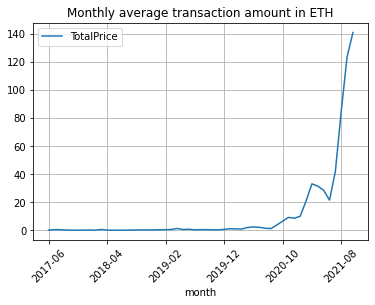

In [161]:
temp = nonzero_trans[['month', 'TotalPrice']].groupby('month').mean()
# temp = temp.set_index(pd.to_datetime(temp.index))
temp.plot(grid=True, rot=45, figsize=(6, 4))
plt.title("Monthly average transaction amount in ETH")
# plt.yticks([0, 200000, 400000, 600000, 800000, 1000000], ["$0", "$200K", "$400K", "$600K", "$800K", "$1,000K"])

Text(0.5, 1.0, 'Daily average transaction amount in ETH')

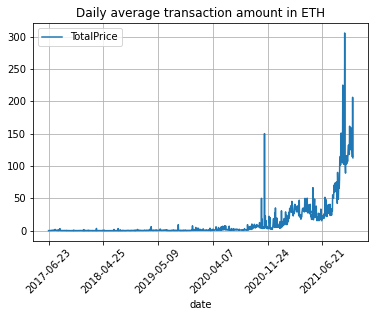

In [162]:
# nonzero_trans[['date', 'TotalPrice']].groupby('date').mean().plot()
# plt.title("Daily average transaction amount in ETH")


temp = nonzero_trans[['date', 'TotalPrice']].groupby('date').mean()
# temp = temp.set_index(pd.to_datetime(temp.index))
temp.plot(grid=True, rot=45, figsize=(6, 4))
plt.title("Daily average transaction amount in ETH")
# plt.yticks([0, 200000, 400000, 600000, 800000, 1000000], ["$0", "$200K", "$400K", "$600K", "$800K", "$1,000K"])

### In USD

In [141]:
sell_df.sort_values('TotalPriceUSD', ascending=False).head()

,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,...,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,Ethereum Open Price,eth_open_price,TotalPriceUSD
21830,0xf2a70bedcc1ea9145cfc2eacc670e798a713b9ad,0x389747708cfe615ca6825243d476c0ebe268e192,2021-09-11 18:41:23,successful,ETH,2000.0,8857,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177099,162686282.0,...,2,0xdf37ac79f8e9b698c4ab57d30a41e7f272331391,NaN,False,0xd8c7928d868a0cc78c8f3827f2af65fefd838410b462a8a6d95913772cba6078,2021-09,2021-09-11,3222.850000,3222.850000,6.445700e+06
89290,0x8f7ceefaa1ff5dfd125106ff9e219eff360d57aa,0xe83c750b2708320bb134796c555b80df39a3d97b,2021-07-30 21:24:47,successful,ETH,2250.0,5217,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178333,142318577.0,...,2,0xe301612b0751f6d862a27be205fb8e3c40c8c6db,NaN,False,0x76869ad4d3c2ddadd5bbc30715bcc6a51616f0ce9a24dee10272925c1448b231,2021-07,2021-07-30,2386.870000,2386.870000,5.370458e+06
51478,0x956d14b8b548ac2db7069ad33d7b86e6d99f2297,0x9fce8eb77fb67660cb134f4ee4c82a48f415f812,2021-08-24 06:34:02,successful,ETH,1600.0,7252,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177080,152625237.0,...,2,0x0a8f4037729accb854da856431a87b8a264d8c40,NaN,False,0xf7ffa7656643d5cad05d748a98a8caff91932a4decf90fac06f36b50c7c05011,2021-08,2021-08-24,3325.178649,3325.178649,5.320286e+06
70743,0xd2c1a0138716f0f9987977111ba14182e6972630,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,2021-09-04 21:39:01,successful,ETH,1319.0,6275,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,177214,158970847.0,...,2,0xd2c1a0138716f0f9987977111ba14182e6972630,NaN,True,0xd8f1cfa6f0aa84068ca121f5672566522c2332f24d3f41c8b10898f3acbafd4d,2021-09,2021-09-04,3787.989114,3787.989114,4.996358e+06
141048,0x7cd3fc0e4ef95897f9b8db951dfc075cc924ebbe,0xfab9b89d9a0317f0f2a0e6643a1c956c66550ed4,2021-08-06 18:18:56,successful,ETH,1500.0,2338,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178953,144996374.0,...,4,0x7cd3fc0e4ef95897f9b8db951dfc075cc924ebbe,NaN,False,0xf6a459ea3161b4c30c666dce101322b9ddcfb3a5635c19a0b8dd9b58c2ade684,2021-08,2021-08-06,2829.048483,2829.048483,4.243573e+06


In [142]:
sell_df['TotalPriceUSD'].describe()

count    1.735500e+04
mean     8.302850e+04
std      1.703382e+05
min      0.000000e+00
25%      2.884556e+02
50%      3.541500e+04
75%      8.370666e+04
max      6.445700e+06
Name: TotalPriceUSD, dtype: float64

In [143]:
# Filter out zero ETH transaction
print(nonzero_trans.shape)
nonzero_trans['TotalPriceUSD'].describe()

(16297, 21)


count    1.629600e+04
mean     8.842413e+04
std      1.744238e+05
min      2.861400e-16
25%      7.359538e+02
50%      3.906697e+04
75%      9.060000e+04
max      6.445700e+06
Name: TotalPriceUSD, dtype: float64

In [144]:
nonzero_trans[['month', 'TotalPriceUSD']].groupby('month').mean()

,TotalPriceUSD
month,
2017-06,60.064261
2017-07,123.531151
2017-08,129.624622
2017-09,69.995127
2017-10,52.882338
2017-11,51.379516
2017-12,120.413247
2018-01,286.007368
2018-02,111.773034


([<matplotlib.axis.YTick at 0x7f93387e4790>,
 [Text(0, 0, '$0'),
  Text(0, 0, '$200K'),
  Text(0, 0, '$400K'),
  Text(0, 0, '$600K'),
  Text(0, 0, '$800K'),
  Text(0, 0, '$1,000K')])

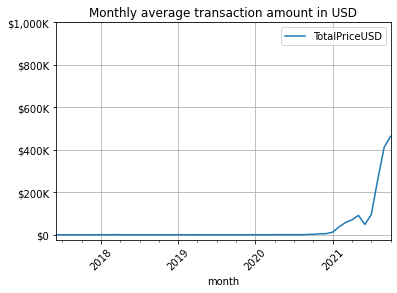

In [165]:
# nonzero_trans[['month', 'TotalPriceUSD']].groupby('month').mean().plot(grid=True)
# plt.title("Monthly average transaction amount in USD")


temp = nonzero_trans[['month', 'TotalPriceUSD']].groupby('month').mean()
temp = temp.set_index(pd.to_datetime(temp.index))
temp.plot(grid=True, rot=45, figsize=(6, 4))
plt.title("Monthly average transaction amount in USD")
plt.yticks([0, 200000, 400000, 600000, 800000, 1000000], ["$0", "$200K", "$400K", "$600K", "$800K", "$1,000K"])

([<matplotlib.axis.YTick at 0x7f933ce3b250>,
 [Text(0, 0, '$0'),
  Text(0, 0, '$200K'),
  Text(0, 0, '$400K'),
  Text(0, 0, '$600K'),
  Text(0, 0, '$800K'),
  Text(0, 0, '$1,000K')])

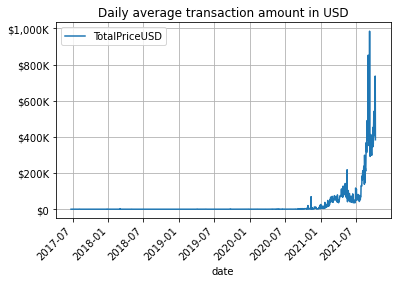

In [156]:
temp = nonzero_trans[['date', 'TotalPriceUSD']].groupby('date').mean()
temp = temp.set_index(pd.to_datetime(temp.index))
temp.plot(grid=True, rot=45, figsize=(6, 4))
plt.title("Daily average transaction amount in USD")
plt.yticks([0, 200000, 400000, 600000, 800000, 1000000], ["$0", "$200K", "$400K", "$600K", "$800K", "$1,000K"])

In [ ]:
nonzero_trans

# How has the "sell" volume changed over time?
Timeline of sell occurrences. Only counting nonzero transactions

Text(0.5, 0, 'Time')

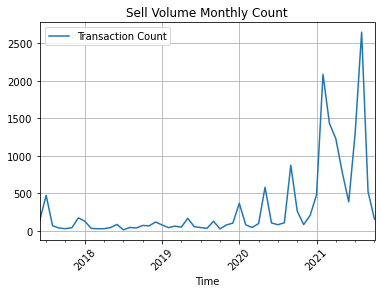

In [170]:
# nonzero_trans[['month', 'TransactionId']].groupby('month').count().plot()
# plt.title("Sell volume occurrences timeline (monthly)")

temp = nonzero_trans[['month', 'TransactionId']].groupby('month').count()
temp = temp.set_index(pd.to_datetime(temp.index))
temp.plot(grid=True, rot=45, figsize=(6, 4))
plt.title("Sell Volume Monthly Count")
plt.legend(['Transaction Count'])
plt.xlabel("Time")
# plt.yticks([0, 200000, 400000, 600000, 800000, 1000000], ["$0", "$200K", "$400K", "$600K", "$800K", "$1,000K"])

Text(0.5, 1.0, 'Sell volume occurrences timeline (daily)')

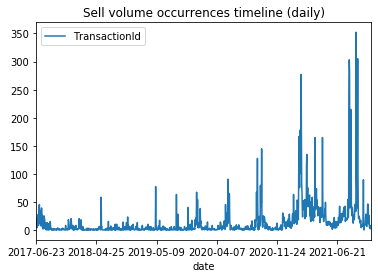

In [34]:
nonzero_trans[['date', 'TransactionId']].groupby('date').count().plot()
plt.title("Sell volume occurrences timeline (daily)")

# Which assets have increased/decreased in price the most?

In [172]:
nonzero_sell_all = edge_df[(edge_df['EventType'] == 'successful') * edge_df['TotalPrice'] > 0]
first_price = nonzero_sell_all.loc[nonzero_sell_all.groupby('TokenId')['Timestamp'].idxmin(), ['TokenId', 'TotalPriceUSD']]
latest_price = nonzero_sell_all.loc[nonzero_sell_all.groupby('TokenId')['Timestamp'].idxmax(), ['TokenId', 'TotalPriceUSD']]

In [173]:
price_change_df = first_price.set_index('TokenId').join(latest_price.set_index('TokenId'), rsuffix="latest")
price_change_df.columns = ['first_trans_price', 'latest_trans_price']
price_change_df['abs_change'] = price_change_df['latest_trans_price'] - price_change_df['first_trans_price']
price_change_df['perc_change'] = (price_change_df['latest_trans_price'] - price_change_df['first_trans_price']) / price_change_df['first_trans_price']

In [174]:
print("Top gain NFT by USD")
price_change_df.sort_values('perc_change', ascending=False).head(10)

Top gain NFT by USD


,first_trans_price,latest_trans_price,abs_change,perc_change
TokenId,,,,
4156,1.919300e-15,1.203039e+06,1.203039e+06,6.268112e+20
1784,2.861400e-16,3.763565e+02,3.763565e+02,1.315288e+18
9923,1.493885e-13,1.124845e+04,1.124845e+04,7.529662e+16
1376,6.090800e-08,4.055955e+04,4.055955e+04,6.659150e+11
5104,2.536800e-04,3.339461e+05,3.339461e+05,1.316407e+09
8100,3.270023e-06,1.340449e+03,1.340449e+03,4.099203e+08
2599,3.460092e-01,4.643719e+05,4.643715e+05,1.342079e+06
5621,9.805500e+00,5.887200e+05,5.887102e+05,6.003877e+04
9513,3.929520e+01,1.104026e+06,1.103987e+06,2.809470e+04


In [175]:
price_change_df.loc[3100]

first_trans_price     7467768.0
latest_trans_price    7467768.0
abs_change            0.0      
perc_change           0.0      
Name: 3100, dtype: float64

In [176]:
print("Note that the famous 3100 Token has no record of non-zero transactions until 4200 ETH")
edge_df[edge_df['TokenId'] == 3100]

Note that the famous 3100 Token has no record of non-zero transactions until 4200 ETH


,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,...,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,Ethereum Open Price,eth_open_price,TotalPriceUSD
126795,NaN,NaN,2021-09-14 22:47:08,bid_withdrawn,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,164374831.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x319aae1e01c1bfcd106c1063cd230a59375368f5,False,0x4724c3c2f089b0eb93e55861bc1e0922e488bd3f464bcc0dd9168c4c5a5eda3d,2021-09,2021-09-14,3280.730000,3280.730000,NaN
126796,NaN,NaN,2021-09-14 11:42:33,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,164099462.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x319aae1e01c1bfcd106c1063cd230a59375368f5,False,0xaa7270b3b1a9bd08cbb0a98eae87b751bfc42ed4eee8644f8372aa26a6cab4c9,2021-09,2021-09-14,3280.730000,3280.730000,NaN
126797,NaN,NaN,2021-08-30 16:00:57,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,156184223.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0x151d89bc14c443d1d3f15465b6be32d443a4f1d8eeb15a044ac2e491fbb88e46,2021-08,2021-08-30,3228.658734,3228.658734,NaN
126798,NaN,NaN,2021-08-28 17:16:36,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,155086705.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0xfe2f0ada3cb1f1aae2d59e7ce78f918a21b4c1c09f25a1984ae87d1094fb9631,2021-08,2021-08-28,3270.666681,3270.666681,NaN
126799,NaN,NaN,2021-08-08 11:16:10,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,145701532.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0xeea014dfe7e902f3848794752de691e1cc583edb,False,0x7460ff1bb67f685d61da7ab168cd133fc588e62b3caa32c528f99c2ba93e99bc,2021-08,2021-08-08,3158.300000,3158.300000,NaN
126800,NaN,NaN,2021-08-01 12:28:41,created,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,142933217.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,False,0x89a0295dc4a1f9fd314585ef19850890939bcb3630434e714c1eefb49943b28d,2021-08,2021-08-01,2524.010000,2524.010000,NaN
126801,NaN,NaN,2021-07-05 10:44:27,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,132847310.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x72fae93d08a060a7f0a8919708c0db74ca46cbb6,False,0x65a84875272bd1610a5eb73dfeefcb180bc98ee5877600b96e8b05df0c6f3858,2021-07,2021-07-05,2317.360000,2317.360000,NaN
126802,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x6611fe71c233e4e7510b2795c242c9a57790b376,2021-03-11 20:57:01,successful,ETH,4200.0,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314752.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,NaN,True,0xa1c6097dedb55e7ba1a1d015be6ec2132cf2f75d636d753c2f21029e7cee4ce7,2021-03,2021-03-11,1778.040000,1778.040000,7467768.0
126803,NaN,NaN,2021-03-11 20:54:14,bid_entered,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,89314182.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,False,0xd46d6d70e6cfa2348a2593683e7c48fc33e8728b5d47eca452f0f4cddbf9e5e3,2021-03,2021-03-11,1778.040000,1778.040000,NaN
126804,NaN,NaN,2021-03-04 06:37:43,bid_withdrawn,ETH,NaN,3100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176563,86909905.0,...,2,0x7b8961f67382c51c389726667ef7dd7cf95fefd3,0x51636d9efbfb79631824dd6107d54f2dcf548359,False,0x9cd50f6e702de68d3dc886818b47dd61c3becbea446b6af107780de9cac4eec5,2021-03,2021-03-04,1563.620000,1563.620000,NaN


In [177]:
print("Top loss NFT in USD")
price_change_df.dropna().sort_values('perc_change', ascending=False).tail(50)

Top loss NFT in USD


,first_trans_price,latest_trans_price,abs_change,perc_change
TokenId,,,,
3760,141.167116,91.496147,-49.670969,-0.351859
6734,88398.334704,57284.880000,-31113.454704,-0.351969
9620,63254.334000,40950.300000,-22304.034000,-0.352609
6402,296157.018932,191250.000000,-104907.018932,-0.354228
2211,61985.413987,40008.289322,-21977.124665,-0.354553
2493,67098.320000,42962.075000,-24136.245000,-0.359715
1813,67098.320000,42761.808400,-24336.511600,-0.362699
3604,67098.320000,42298.240300,-24800.079700,-0.369608
7343,93.716700,58.477000,-35.239700,-0.376024


In [178]:
edge_df[edge_df['TokenId'] == 8432]

,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,...,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,Ethereum Open Price,eth_open_price,TotalPriceUSD
30031,NaN,NaN,2021-04-27 16:28:17,bid_withdrawn,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,106913338.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x023ef73d4c6de80dd3e52b8aae579b8f0e5cbeb4,False,0xb386f2c74ec29d7c29c7ed1bb7b98ea5f7e1ee27fd8ffdb2a357b5077070dd3f,2021-04,2021-04-27,2534.000000,2534.000000,NaN
30032,NaN,NaN,2021-04-25 16:02:41,bid_entered,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,106083397.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x023ef73d4c6de80dd3e52b8aae579b8f0e5cbeb4,False,0xd986412844ac6bb4f0a1574c176946d32600157077193fd8802d261221f8196d,2021-04,2021-04-25,2231.000000,2231.000000,NaN
30033,NaN,NaN,2021-03-06 17:21:55,bid_withdrawn,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,87706566.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x36d1b7bb2e85cb2ee082ebb5bc48eda3b564ec8e,False,0x93831cdcdacf00ace28ca4572b4aaef9ea136acc8198e920e4016fd5d03ecb4e,2021-03,2021-03-06,1534.820000,1534.820000,NaN
30034,NaN,NaN,2021-03-06 16:47:50,bid_entered,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,87698854.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x36d1b7bb2e85cb2ee082ebb5bc48eda3b564ec8e,False,0xd36290740e0050068e9a1c79784ae9ce3a997bd8a94f43045397ae5cdb2dc52f,2021-03,2021-03-06,1534.820000,1534.820000,NaN
30035,NaN,NaN,2021-03-05 17:03:52,bid_withdrawn,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,87392355.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x696ed7b26f4b019ceec78dc8b9140ad64a6f354b,False,0x618442176b14f6ccdf7e29d07bc934435334ba303f7f653a503bdfb4a3d678fb,2021-03,2021-03-05,1540.860000,1540.860000,NaN
30036,NaN,NaN,2021-03-05 16:05:05,bid_entered,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,87379226.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x696ed7b26f4b019ceec78dc8b9140ad64a6f354b,False,0x9e13e48302d7779058707f62366edfac8754215f003688d71c90c5e8367bfd0b,2021-03,2021-03-05,1540.860000,1540.860000,NaN
30037,NaN,NaN,2021-03-05 15:47:58,bid_entered,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,87375533.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x36d1b7bb2e85cb2ee082ebb5bc48eda3b564ec8e,False,0xfd3f0b40d9a5057aa3d767ce4248878e9f088120c59a3cc3e3529b1ab9184125,2021-03,2021-03-05,1540.860000,1540.860000,NaN
30038,NaN,NaN,2021-03-05 15:37:54,bid_withdrawn,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,87373155.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x36d1b7bb2e85cb2ee082ebb5bc48eda3b564ec8e,False,0x0317357745fbc43a31c3fee8fe314c4ca991114e6a33189edc3588d34b416d18,2021-03,2021-03-05,1540.860000,1540.860000,NaN
30039,NaN,NaN,2021-03-05 15:07:59,bid_entered,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,87366596.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0x36d1b7bb2e85cb2ee082ebb5bc48eda3b564ec8e,False,0x41b6acc764e709bd4d46a09379b536b5216a3be9917ab146c9347cd4d2cafdcb,2021-03,2021-03-05,1540.860000,1540.860000,NaN
30040,NaN,NaN,2021-02-14 19:11:48,bid_withdrawn,ETH,NaN,8432,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178563,81823163.0,...,2,0x0a4eafeb533d4111a1fe3a8b323c468976ac2323,0xe369a8d4e8799d381cd5734eafd812cfb5c2574a,False,0x141cbe37c3961ad5927eadd79d029b924c8ccb3dd5679b5752670e3fcb2cffeb,2021-02,2021-02-14,1817.838911,1817.838911,NaN


# Which assets have been sold the most? How has this price changed over time? How many people have held this asset?

**Note that the dataset does NOT have off-platform transactions**

**Note that we took out zero ETH transactions **

In [179]:
print("Top 10 most-sold asset")
nonzero_sell_all[['TokenId', 'TransactionId']].groupby('TokenId').count().sort_values('TransactionId', ascending=False).head(10)

Top 10 most-sold asset


,TransactionId
TokenId,
3914,16
8970,14
6989,14
2937,13
2832,13
6788,13
4130,12
9507,12
9322,12


In [180]:
nonzero_sell_all[nonzero_sell_all['TokenId'] == 3914]

,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,...,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,Ethereum Open Price,eth_open_price,TotalPriceUSD
110779,0xd93bc9654df5a50e0e65df55d09ba7b47fb95cd,0xccc003f10b7278d86fbe56f5c40d1feb4d2b9e40,2021-08-07 00:51:31,successful,ETH,100.00,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,145109237.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,True,0xb040d5d08406884a3d71ebef651d789ed3c6b5f3fc59b4918a1fe2d1c666d648,2021-08,2021-08-07,2891.193238,2891.193238,289119.323780
110786,0xccc003f10b7278d86fbe56f5c40d1feb4d2b9e40,0x20a6f27e11edc08d32c21454b4625eecfb22bb21,2021-08-01 17:15:34,successful,ETH,66.66,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,143015042.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0xef5bff3f9b0f8eb37ac7962eee35215c752aa6b8ec75f6157300c9c3eb9743ef,2021-08,2021-08-01,2524.010000,2524.010000,168250.506600
110794,0x20a6f27e11edc08d32c21454b4625eecfb22bb21,0x850cae094ce34c564327818631287a75d3cee6ca,2021-07-30 20:11:58,successful,ETH,42.88,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,142295785.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0x1a75abd2534759db806c865e59c027a8b1dce4eee3b9c591345230c649570006,2021-07,2021-07-30,2386.870000,2386.870000,102348.985600
110801,0x850cae094ce34c564327818631287a75d3cee6ca,0x8a3d2efdb70c3fa23e0f38bdcb95c4f39ad1e127,2021-07-26 07:51:48,successful,ETH,38.00,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,140458394.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0x194ed127425ff02d94a763fb5bbc12a918a94f72ba231c6deefc515b18b3d3e3,2021-07,2021-07-26,2192.909356,2192.909356,83330.555544
110828,0x8a3d2efdb70c3fa23e0f38bdcb95c4f39ad1e127,0x6ec30fd91a504aad948839b985c7263888b2ad68,2021-04-17 05:29:40,successful,ETH,35.88,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,103045323.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0xb19600990b3b63c7dc7b49f12d65454b0a4a05bb071d446ca7f2e3aa140c68d5,2021-04,2021-04-17,2421.891770,2421.891770,86897.476714
110846,0x6ec30fd91a504aad948839b985c7263888b2ad68,0x4c6d87a0df5024003b1439a2152bb2d622ca342b,2021-04-12 22:59:29,successful,ETH,42.00,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,100774419.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0x209b865263132e2826cbee9286c9e92b5100592ab838698e4ce82e9d1b82102c,2021-04,2021-04-12,2150.540000,2150.540000,90322.680000
110851,0x4c6d87a0df5024003b1439a2152bb2d622ca342b,0x13816f65ba8195768e6825eb774fd3c6a05a0ac8,2021-02-22 22:54:46,successful,ETH,42.00,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,84162518.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0xd3f1844e421a5b38284a36021df792ed997c75838d7946b04b6c777eb874fb3f,2021-02,2021-02-22,1937.390000,1937.390000,81370.380000
110856,0x13816f65ba8195768e6825eb774fd3c6a05a0ac8,0xadc229c0dbec4af386ac7b96920369f9770ee6e0,2021-02-21 21:38:55,successful,ETH,25.00,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,83856378.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0x14bce569c8bcd715e0c692f3ec219c94aff45393ba5651d7eb893f58d4f3c332,2021-02,2021-02-21,1914.610000,1914.610000,47865.250000
110862,0xadc229c0dbec4af386ac7b96920369f9770ee6e0,0xfc624f8f58db41bdb95aedee1de3c1cf047105f1,2021-01-31 01:36:50,successful,ETH,7.00,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,77719422.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0x9a2f5c0201dfa50949505d95688ad6540711b93143bd84d020c4e5a6b02deff6,2021-01,2021-01-31,1373.371504,1373.371504,9613.600530
110868,0xfc624f8f58db41bdb95aedee1de3c1cf047105f1,0xee3766e4f996dc0e0f8c929954eaafef3441de87,2021-01-24 00:06:11,successful,ETH,5.49,3914,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178723,76058503.0,...,16,0x0d93bc9654df5a50e0e65df55d09ba7b47fb95cd,NaN,False,0xb13b4e1215b61f

([<matplotlib.axis.YTick at 0x7f933a026af0>,
 [Text(0, 0, '$0'),
  Text(0, 0, '$100K'),
  Text(0, 0, '$200K'),
  Text(0, 0, '$300K'),
  Text(0, 0, '$400K')])

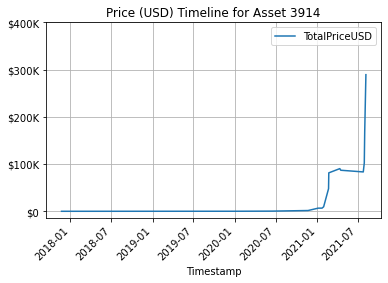

In [185]:
nonzero_sell_all[nonzero_sell_all['TokenId'] == 3914].plot(x='Timestamp', y="TotalPriceUSD", grid=True, rot=45, figsize=(6, 4))
plt.title("Price (USD) Timeline for Asset 3914")

# # nonzero_trans[['month', 'TransactionId']].groupby('month').count().plot()
# # plt.title("Sell volume occurrences timeline (monthly)")

# temp = nonzero_trans[['month', 'TransactionId']].groupby('month').count()
# temp = temp.set_index(pd.to_datetime(temp.index))
# temp.plot(grid=True, rot=45, figsize=(6, 4))
# plt.title("Sell Volume Monthly Count")
# plt.legend(['Transaction Count'])
# plt.xlabel("Time")
plt.yticks([0, 100000, 200000, 300000, 400000], ["$0", "$100K", "$200K", "$300K", "$400K"])

Text(0.5, 1.0, 'Price (ETH) Timeline for Asset 3914')

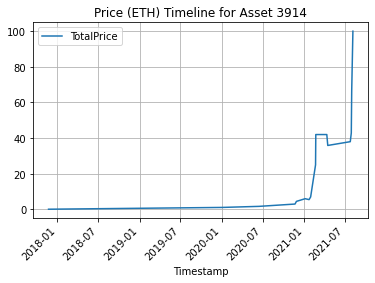

In [187]:
nonzero_sell_all[nonzero_sell_all['TokenId'] == 3914].plot(x='Timestamp', y="TotalPrice", grid=True, rot=45, figsize=(6, 4))
plt.title("Price (ETH) Timeline for Asset 3914")

In [46]:
total_count = len(set(sell_df.loc[sell_df['TokenId'] == 3914, 
                                  ['SellerAddress', 'WinnerAddress']].values.flatten())) - 1
print("Wallets that have owned the asset 3914 (TOTAL {} excluding nan and 0x00):".format(total_count))
set(sell_df.loc[sell_df['TokenId'] == 3914, ['SellerAddress', 'WinnerAddress']].values.flatten())

Wallets that have owned the asset 3914 (TOTAL 20 excluding nan and 0x00):


{'0x0d41f957181e584db82d2e316837b2de1738c477',
 '0x13816f65ba8195768e6825eb774fd3c6a05a0ac8',
 '0x20a6f27e11edc08d32c21454b4625eecfb22bb21',
 '0x4c6d87a0df5024003b1439a2152bb2d622ca342b',
 '0x50c946cb9757d6de490099c0ec185a0dfe29974b',
 '0x51ec5e1b8b3c4c6bae49619e657f94c4ad577b45',
 '0x566f193d80c76a324cf5e521d62657f4c4d4ccc5',
 '0x5b331eb6df00b5765894f88e54d2a87128188ec7',
 '0x624394c3e8699980162fa15e23fdb707d9a53517',
 '0x6ec30fd91a504aad948839b985c7263888b2ad68',
 '0x850cae094ce34c564327818631287a75d3cee6ca',
 '0x8a3d2efdb70c3fa23e0f38bdcb95c4f39ad1e127',
 '0xadc229c0dbec4af386ac7b96920369f9770ee6e0',
 '0xbfa319ef5529b88a0ad94dcc36d438dcafac0e52',
 '0xccc003f10b7278d86fbe56f5c40d1feb4d2b9e40',
 '0xd41f957181e584db82d2e316837b2de1738c477',
 '0xd93bc9654df5a50e0e65df55d09ba7b47fb95cd',
 '0xee3766e4f996dc0e0f8c929954eaafef3441de87',
 '0xee402489d83e2b22d496910f8c810d35a3ad7b25',
 '0xfc624f8f58db41bdb95aedee1de3c1cf047105f1',
 nan}

# Which wallet has the most CryptoPunks assets?

In [47]:
print("Current ownership top 10:")
edge_df[['TokenId', 'AssetOwnerAddress']].drop_duplicates()['AssetOwnerAddress'].value_counts().head(10)

Current ownership top 10:


0xb7f7f6c52f2e2fdb1963eab30438024864c313f6    256
0xa25803ab86a327786bb59395fc0164d826b98298    253
0xc352b534e8b987e036a93539fd6897f53488e56a    241
0xb88f61e6fbda83fbfffabe364112137480398018    215
0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647    172
0x69021ae8769586d56791d29615959997c2012b99    147
0xcffc336e6d019c1af58257a0b10bf2146a3f42a4    125
0x269616d549d7e8eaa82dfb17028d0b212d11232a    104
0xd79b937791724e47f193f67162b92cdfbf7abdfd    102
0x4084df8bf74ba73f04eb39b89df698608df7f4b5    98 
Name: AssetOwnerAddress, dtype: int64


# Which wallet has bought assets the most?

In [48]:
print("Purchase count by wallet (top 10)")
sell_df['WinnerAddress'].value_counts().head(10)

Purchase count by wallet (top 10)


0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459    426
0x269616d549d7e8eaa82dfb17028d0b212d11232a    230
0x1919db36ca2fa2e15f9000fd9cdc2edcf863e685    179
0x7d438bf6567673867480b7923669bf349e6c8c12    162
0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7    133
0x78f0269f5b1ca914c8c58993f41181f89e212b27    114
0x650dcdeb6ecf05ae3caf30a70966e2f395d5e9e5    106
0xdde8df9a7dc9f68bdac815f493d1d731de911b5a    102
0x303052148a78a692d7aa89bad454f3e91785488d    100
0x62bdc64a14405e797f86796ea3c2476209ee0bf9    99 
Name: WinnerAddress, dtype: int64

# Which wallet has the most transaction (all types) in CryptoPunks?

In [49]:
transaction_count_by_wallet = pd.DataFrame([edge_df['SellerAddress'].value_counts(), edge_df['WinnerAddress'].value_counts(), edge_df['FromAccountAddress'].value_counts()])
transaction_count_by_wallet = transaction_count_by_wallet.transpose()
transaction_count_by_wallet.columns = ['sell_count', 'win_count', 'bid_count']
transaction_count_by_wallet['total'] = np.sum(transaction_count_by_wallet, axis=1)
transaction_count_by_wallet = transaction_count_by_wallet.fillna(0).astype('int')

In [50]:
print("Top 20 wallets with the highest transaction counts:")
transaction_count_by_wallet.sort_values('total', ascending=False).head(20)

Top 20 wallets with the highest transaction counts:


,sell_count,win_count,bid_count,total
0xb7f7f6c52f2e2fdb1963eab30438024864c313f6,0,0,2521,2521
0x7174039818a41e1ae40fdcfa3e293b0f41592af2,0,167,2093,2260
0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,237,426,1293,1956
0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a,409,18,798,1225
0x00d7c902fbbcd3c9db2da80a439c94486c50eb81,0,20,779,799
0xcbd482af76059e2a5e4a825c4cd5ced9f2dfe286,54,0,729,783
0xc352b534e8b987e036a93539fd6897f53488e56a,139,53,576,768
0x899241b0c41051313ce36271a7e13d54c94877a1,37,53,576,666
0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,346,34,260,640
0x696ed7b26f4b019ceec78dc8b9140ad64a6f354b,40,46,550,636


# Which wallet has gained/lost the most so far in CryptoPunks?

In [51]:
def calculate_sellUSD(wallet_addr):
    return edge_df.loc[edge_df['SellerAddress'] == wallet_addr, 'TotalPriceUSD'].sum()

def calculate_purchaseUSD(wallet_addr):
    return edge_df.loc[edge_df['WinnerAddress'] == wallet_addr, 'TotalPriceUSD'].sum()

In [52]:
transaction_count_by_wallet['sellUSD'] = [calculate_sellUSD(addr) for addr in transaction_count_by_wallet.index]
transaction_count_by_wallet['purchaseUSD'] = [calculate_purchaseUSD(addr) for addr in transaction_count_by_wallet.index]
transaction_count_by_wallet['netUSD'] = transaction_count_by_wallet['sellUSD'] - transaction_count_by_wallet['purchaseUSD']

In [53]:
print("Wallet that gained the most by USD (top 10)")
transaction_count_by_wallet.sort_values('netUSD', ascending=False).head(10)

Wallet that gained the most by USD (top 10)


,sell_count,win_count,bid_count,total,sellUSD,purchaseUSD,netUSD
0x6611fe71c233e4e7510b2795c242c9a57790b376,154,95,122,371,2.994572e+07,9.357039e+05,2.901002e+07
0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,346,34,260,640,2.641242e+07,2.646034e+06,2.376639e+07
0x6f4a2d3a4f47f9c647d86c929755593911ee91ec,221,5,4,230,2.305918e+07,7.596340e+04,2.298322e+07
0xcc7c335f3365ae3f7e4e8c9535dc92780a4add9d,72,3,15,90,1.618545e+07,4.221858e+05,1.576327e+07
0x00b278dd68f9d8491795ffaf771120638bef1686,42,61,6,109,1.240190e+07,5.075854e+03,1.239682e+07
0x0b88fd87884080bd6d93d341fcca0eea76b03e75,94,10,0,104,1.076503e+07,6.635070e+05,1.010152e+07
0x8f6b1e467fbe74d7dd43d59de0558f693c736798,34,12,3,49,1.044419e+07,6.944456e+05,9.749749e+06
0xfeeb2d7f276b319896f71431ef64fdf1e4ab8d5b,43,0,0,43,9.104756e+06,0.000000e+00,9.104756e+06
0x03911fecabd6b4809c88e2e6eb856ec932b2ee3e,2,7,11,20,9.019228e+06,5.278276e+03,9.013950e+06
0xe83c750b2708320bb134796c555b80df39a3d97b,9,33,67,109,9.168184e+06,1.964153e+05,8.971768e+06


In [58]:
print("Wallet that lost the most by USD (bottom 50) among those who have sold something")
print("The one from the bottom has lost the most!!!")
bottom10 = transaction_count_by_wallet.sort_values('netUSD', ascending=False)
bottom10[bottom10['sell_count'] > 0].tail(50)

Wallet that lost the most by USD (bottom 50) among those who have sold something
The one from the bottom has lost the most!!!


,sell_count,win_count,bid_count,total,sellUSD,purchaseUSD,netUSD
0xb5e6acc6cbb5d712a96fcc7a8fe25a69f10ecf4c,6,10,37,53,8.569791e+05,1.686974e+06,-8.299945e+05
0x25f9e2399a962b38ad0c022b6da53c3528b5e919,5,9,0,14,1.534058e+06,2.368919e+06,-8.348612e+05
0x9293c35d6e1524609b7221a1c9a8d52dc81ba62c,1,5,0,6,5.684992e+04,9.163477e+05,-8.594978e+05
0x0a53e28f2f7b27971e18a6305c2c74a449badd2e,3,5,0,8,8.942283e+05,1.765108e+06,-8.708792e+05
0xeb725fcecce376a174675c87287bac30d46fdbe8,14,34,43,91,5.696225e+05,1.446137e+06,-8.765146e+05
0x9f719e0bc35c46236b3f450852b526d84fed514b,1,3,2,6,5.156930e+05,1.394399e+06,-8.787062e+05
0x53311150764f7eb2999022ed1aa5a8c17bb5fc57,2,7,0,9,4.638024e+05,1.352376e+06,-8.885740e+05
0xbec69dfce4c1fa8b7843fee1ca85788d84a86b06,49,55,143,247,3.981136e+06,4.877442e+06,-8.963066e+05
0x701f373df763308d96d8537822e8f9b2bae4e847,11,31,46,88,7.511143e+05,1.658059e+06,-9.069449e+05
0xebea4c9bccafebc35bf26688b0b103072a193779,1,2,17,20,4.546616e+05,1.395913e+06,-9.412516e+05


##### History of the top worth wallets

In [59]:
top_wallet = '0x6611fe71c233e4e7510b2795c242c9a57790b376'
edge_df[(edge_df['SellerAddress'] == top_wallet) | 
        (edge_df['WinnerAddress'] == top_wallet) |
        (edge_df['FromAccountAddress'] == top_wallet)]
# Note that this one is missing two rows. Let me know if you want me to trace those down

,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,BidAmount,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,eth_open_price,TotalPriceUSD
412,0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7,0x6611fe71c233e4e7510b2795c242c9a57790b376,2021-08-28 07:00:56,successful,ETH,105.0000,9138,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530600,154861386.0,NaN,7,0x3d0ad943a22172fa0ced3a1ce04d027557a5c85e,NaN,False,0xa685a80ce54211e6fae2ed2d9ad5ba1b8e7ec8b54701949b646f4831ee564d07,2021-08,2021-08-28,3270.666681,343420.001524
415,0x6611fe71c233e4e7510b2795c242c9a57790b376,0x1f5a39931bfcf3ed01fd2d33febb1aa385e26a0c,2021-03-15 20:12:30,successful,ETH,24.9900,9138,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530600,90656707.0,NaN,7,0x3d0ad943a22172fa0ced3a1ce04d027557a5c85e,NaN,False,0x84ec54b54cb3b24b072ac76780c1fcdc47bcd0c1a541d4b7e493573718fbf807,2021-03,2021-03-15,1848.412961,46191.839886
839,NaN,NaN,2021-10-10 02:23:45,transfer,NaN,NaN,9115,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530586,178993826.0,NaN,0,0x8e232860171762f6ff2d22d1fcc45af78bd3fbb5,0x6611fe71c233e4e7510b2795c242c9a57790b376,False,0xd4a42107731fab97346c1a6d669c50a6d75ee13fc545169fb0360d837ccbe75c,2021-10,2021-10-10,3571.700000,NaN
2426,0x6611fe71c233e4e7510b2795c242c9a57790b376,0xcaf6fd54fb74c95b28f5e94952ca21b46e4071cc,2021-03-15 20:12:56,successful,ETH,25.9900,9910,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,531056,90656884.0,NaN,4,0x6611fe71c233e4e7510b2795c242c9a57790b376,NaN,False,0x253caf725d3b1a19964d47f341ea1af4cbafd8fb8eee1d537c02a54951989fff,2021-03,2021-03-15,1848.412961,48040.252847
2864,NaN,NaN,2021-04-06 22:18:18,transfer,NaN,NaN,9103,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530578,97747203.0,NaN,4,0xdee19f2692a45654ff92c611ed8ed101fee0ddd8,0x6611fe71c233e4e7510b2795c242c9a57790b376,False,0xc6e28aabda66bdd9791f4c1572a8646c4868a878c21b5b1221ce9801ee3fa1a4,2021-04,2021-04-06,2115.970000,NaN
2889,0xb70c1a3242e363b4772b83acdc10df94e6c3fb02,0x6611fe71c233e4e7510b2795c242c9a57790b376,2021-04-20 00:49:43,successful,ETH,37.7500,9102,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178862,104026503.0,NaN,2,0xb70c1a3242e363b4772b83acdc10df94e6c3fb02,NaN,False,0x33405921e30b89f8672b2e76baa3940c84cc658def1dc48027e3d815628a527f,2021-04,2021-04-20,2170.810000,81948.077500
2895,0x6611fe71c233e4e7510b2795c242c9a57790b376,NaN,2017-07-04 04:56:32,successful,ETH,0.4900,9102,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178862,357825.0,NaN,2,0xb70c1a3242e363b4772b83acdc10df94e6c3fb02,NaN,False,0x535c573b452c0634f8b82f47220734867faec52b376472fa8270a20a1b65e459,2017-07,2017-07-04,269.050000,131.834500
2922,NaN,NaN,2021-08-23 17:24:50,transfer,NaN,NaN,9100,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530577,152324007.0,NaN,1,0x3310d7d9c7e757b0ea97a43e9b0c8d7d6c505ebe,0x6611fe71c233e4e7510b2795c242c9a57790b376,False,0xe91bc01fd91880c57cfb1d2ef375d8fdcdfa158ce9f674977574b3ae2ce82903,2021-08,2021-08-23,3238.999045,NaN
2961,0x899241b0c41051313ce36271a7e13d54c94877a1,0x6611fe71c233e4e7510b2795c242c9a57790b376,2021-03-08 04:52:50,successful,ETH,20.7500,9099,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530576,88174929.0,NaN,4,0xb0dafc466871c29662e5cbf4227322c96a8ccbe9,NaN,False,0x37a071911f88d61f69719e9edf488cd37288f480bfcc4bfe29cfa28eceb0da92,2021-03,2021-03-08,1739.330000,36091.097500
2983,NaN,NaN,2021-04-09 16:08:20,transfer,NaN,NaN,9097,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178344,99075902.0,NaN,1,0x449c69df8487c9faf14d0b798f142ee128cd4fc8,0x6611fe71c233e4e7510b2795c242c9a57790b376,False,0x9c16b3be0047168923a7e44e7bb593c4c0b75417157c817ec3e12532016d5594,2021-04,2021-04-09,2079.055338,NaN


In [60]:
top_wallet2 = '0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647'
edge_df[(edge_df['SellerAddress'] == top_wallet2) | 
        (edge_df['WinnerAddress'] == top_wallet2) |
        (edge_df['FromAccountAddress'] == top_wallet2)]

,WinnerAddress,SellerAddress,Timestamp,EventType,PaymenTokenSymbol,TotalPrice,TokenId,AssetContractAddress,AssetId,TransactionId,BidAmount,AssetNumSales,AssetOwnerAddress,FromAccountAddress,UsedEthscan,TransactionHash,month,date,eth_open_price,TotalPriceUSD
235,NaN,NaN,2021-02-06 16:27:26,transfer,NaN,NaN,9146,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530605,79451945.0,NaN,3,0x269616d549d7e8eaa82dfb17028d0b212d11232a,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,False,0xdc747cb4f3615442801f13e145effeae65393da1610eec8f0b9c044c9534375f,2021-02,2021-02-06,1723.176872,NaN
238,0x8dbbca57ea56290efa14d835bbfd34faf1d89753,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,2021-02-10 15:19:13,successful,ETH,19.00,9145,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,178985,80609187.0,NaN,1,0x2754637ab168ff25412b74997c0e4f43c30bb323,NaN,True,0xc077a3598213439b32d68db79b04b0b9b235229f007ea6867649bcbd1d6b08a0,2021-02,2021-02-10,1774.836693,33721.897163
747,0xf5c1d55e94726962b4b517c949120c42d646e455,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,2021-04-16 00:35:10,successful,ETH,22.00,9119,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530589,102533012.0,NaN,2,0x254459b53c747e96d8a8a0f4d52ac054559f817d,NaN,False,0xb96f1126a85857fc29a287d0872995d91127590e61d21e255598e7e9dcf8e1ea,2021-04,2021-04-16,2516.645382,55366.198412
2054,0x4665591f58492fb56ca41e4b85ea567562f1134f,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,2021-07-13 12:23:15,successful,ETH,21.49,9922,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,531063,135750638.0,NaN,5,0x4665591f58492fb56ca41e4b85ea567562f1134f,NaN,False,0x279fb092137220ff29c144977c48b0e0a42f769abd57b88a7078cd70adc777e0,2021-07,2021-07-13,2030.937309,43644.842771
4343,0x8ce5d6a77a333feb136c2ae90254224ae63da14f,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,2021-02-18 22:57:11,successful,ETH,15.00,9840,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,531021,83023303.0,NaN,7,0xe5200a0066e9893372e7d8a1f5dd28a9896d2e67,NaN,False,0x1e9e7fcabf8da16a1a5f4fc14a155d4bf28ad28390f1556da65550963ff57975,2021-02,2021-02-18,1850.828865,27762.432979
4989,NaN,NaN,2021-02-06 15:38:30,transfer,NaN,NaN,9801,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530995,79441351.0,NaN,0,0x9df947cd8a9810964473339c38a95201ecbe112d,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,False,0xdf1ccefe4d1c9df103760cd6a31892c041653d8f179be480e6a9c258e5014168,2021-02,2021-02-06,1723.176872,NaN
5950,0xd72bb0961368f1a5c566e0ac3afca62affa20f14,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,2021-08-02 19:23:01,successful,ETH,317.00,9749,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176910,143425377.0,NaN,6,0xd72bb0961368f1a5c566e0ac3afca62affa20f14,NaN,False,0xbed1dc6dae20215ddffaf0b66fefe917e4c8d7a3147f58b2cf1ab1f13bc291aa,2021-08,2021-08-02,2562.690000,812372.730000
5955,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,0xa34d2deb99da3bc49d9c55a1625ba44a553d487e,2021-07-31 05:18:59,successful,ETH,275.00,9749,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,176910,142452398.0,NaN,6,0xd72bb0961368f1a5c566e0ac3afca62affa20f14,NaN,False,0xd4e22ef1371d3a86bf5b03df9ff686c7ceda58a649e016580a91bbc823ca1be0,2021-07,2021-07-31,2453.930754,674830.957260
6052,0xdaf1060f23583ee0088dabc18719965b365ed66a,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,2021-07-24 16:54:06,successful,ETH,20.00,9747,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530963,139842260.0,NaN,4,0x269616d549d7e8eaa82dfb17028d0b212d11232a,NaN,False,0x8ebe58c7cf9cda4980908ac679ae9db268c96c61fc4cb9ba3c9893151e32aa74,2021-07,2021-07-24,2113.340000,42266.800000
6058,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647,0xed98464bda3ce53a95b50f897556bede4316361c,2021-05-14 17:40:08,successful,ETH,14.97,9747,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,530963,114234650.0,NaN,4,0x269616d549d7e8eaa82dfb17028d0b212d11232a,NaN,False,0xcec193c219f3f3ffc3ba2a0f0dc1f6aaab88ca8bf283b1f6a0e06fc697eb7ac5,2021-05,2021-05-14,3708.950000,55522.981500


# Which sell transaction was the biggest gain/loss in CryptoPunks?

In [61]:
prev_tok = -1
prev_winner = ''
prev_price = -10
prev_datetime = None

resell_trans = []
for ind in range(len(nonzero_sell_all)-1, 0, -1):
    row = nonzero_sell_all.iloc[ind]
    if prev_tok == row['TokenId']:
        if prev_winner == row['SellerAddress']:
            resell_trans.append([row['TokenId'], row['SellerAddress'], prev_datetime, prev_price, row['Timestamp'], row['TotalPriceUSD'], row['TotalPriceUSD'] - prev_price])
            
    prev_tok = row['TokenId']
    prev_winner = row['WinnerAddress']
    prev_price = row['TotalPriceUSD']
    prev_datetime = row['Timestamp']

In [62]:
resell_trans_df = pd.DataFrame(resell_trans, columns = ['TokenId', 'SellerAddress', 'BoughtTimestamp', 'BoughtPrice', 'SoldTimestamp', 'SoldPrice', 'NetGain'])

In [63]:
print("Top 10 net gain transactions:")
resell_trans_df.sort_values('NetGain', ascending=False).head(10)

Top 10 net gain transactions:


,TokenId,SellerAddress,BoughtTimestamp,BoughtPrice,SoldTimestamp,SoldPrice,NetGain
6281,8888,0x301874ccffa7587ccddf8a6198fb91fb9878fcc9,2021-02-27 09:40:50,4.783741e+04,2021-08-28 14:24:55,2.906969e+06,2.859131e+06
5017,7252,0x9fce8eb77fb67660cb134f4ee4c82a48f415f812,2021-08-04 02:31:27,2.512638e+06,2021-08-24 06:34:02,5.320286e+06,2.807648e+06
974,2140,0x49705967e4a9e3688a393e88eea088562c56ee1f,2021-03-02 01:02:37,1.179675e+06,2021-07-30 18:36:56,3.818992e+06,2.639317e+06
2433,3831,0xf6bc89cc57e33c4e8053c4d8e63b70bf8c47e1a1,2021-01-24 17:28:07,8.580072e+04,2021-07-30 23:45:46,2.028840e+06,1.943039e+06
4810,6965,0x03911fecabd6b4809c88e2e6eb856ec932b2ee3e,2018-01-01 21:47:21,3.024800e+03,2021-02-19 14:27:08,1.551460e+06,1.548435e+06
6718,9052,0xc72aed14386158960d0e93fecb83642e68482e4b,2021-01-07 20:24:00,2.189993e+04,2021-08-27 02:08:52,1.542409e+06,1.520509e+06
6610,9373,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,2021-08-01 11:03:55,3.659815e+05,2021-08-28 17:51:27,1.635301e+06,1.269319e+06
4225,6275,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,2021-09-04 15:13:02,3.787989e+06,2021-09-04 21:39:01,4.996358e+06,1.208369e+06
2662,4156,0x9e199d8a3a39c9892b1c3ae348a382662dcbaa12,2018-09-17 20:28:48,6.449716e+02,2021-02-18 16:19:27,1.203039e+06,1.202394e+06
642,1615,0x00b278dd68f9d8491795ffaf771120638bef1686,2017-07-04 13:42:48,9.551275e+01,2021-08-28 04:46:54,1.112027e+06,1.111931e+06


In [65]:
print("Bottom 10 net gain transactions:")
resell_trans_df.sort_values('NetGain', ascending=False).tail(50)

Bottom 10 net gain transactions:


,TokenId,SellerAddress,BoughtTimestamp,BoughtPrice,SoldTimestamp,SoldPrice,NetGain
1548,2834,0x91338ccfb8c0adb7756034a82008531d7713009d,2021-09-16 10:22:17,397721.500000,2021-09-26 10:56:14,3.359770e+05,-61744.511691
3315,5069,0x4762521fd7998a55996a3fd5e70b8d11ab543fed,2021-08-30 16:17:38,355152.460740,2021-09-15 23:38:05,2.922042e+05,-62948.278040
723,1737,0x899241b0c41051313ce36271a7e13d54c94877a1,2021-05-06 02:24:55,132340.139335,2021-05-21 23:37:12,6.936287e+04,-62977.269941
3004,4610,0xadd1cc0ce160e37611892ef163b0b8b6e58abe17,2021-09-05 10:08:08,380686.083646,2021-09-09 19:55:28,3.151469e+05,-65539.224736
3354,5123,0xd19e7d1ba4a11458a9cf925967e47a15a24a9ef8,2021-09-03 17:50:50,359858.965798,2021-09-26 09:20:16,2.924082e+05,-67450.794947
5846,8375,0x2befb4c92c3af21107165ca4b7c230a3615201eb,2021-08-31 16:48:42,409859.468345,2021-09-30 19:52:27,3.420168e+05,-67842.668345
2468,3860,0x4eea85960a590b942fa81fcb55c028496bab6cc8,2021-07-29 11:33:25,69015.639984,2021-08-04 09:45:41,2.487512e-13,-69015.639984
2170,3517,0xc34f37006cb57957b5296e9d7cd4f71958ec0b8f,2021-09-02 04:55:36,359415.543867,2021-09-11 13:23:36,2.900565e+05,-69359.043867
6174,8726,0xbec69dfce4c1fa8b7843fee1ca85788d84a86b06,2021-05-15 20:30:34,114618.770100,2021-07-16 19:23:30,4.468369e+04,-69935.081504
1021,2224,0x7f9b1c94dbab6f3f5299e30eb9f9b8845d45614b,2021-09-02 17:38:27,378573.665740,2021-09-25 00:46:42,3.077589e+05,-70814.753366


# How many assets are listed on CryptoPunks in OpenSea??

In [66]:
print(len(edge_df['TokenId'].unique()))

9320


# How many have been traded?

In [67]:
print(len(edge_df.loc[edge_df['EventType'].isin(['successful', 'transfer'])].drop_duplicates()['TokenId'].unique()))

8458


# Timeline of "creation" event occurrence

Text(0.5, 1.0, 'Creation event occurrences timeline (daily)')

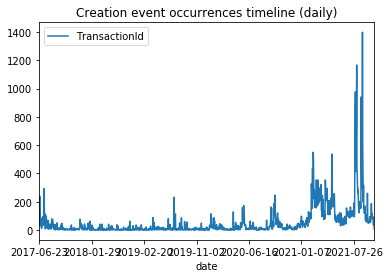

In [68]:
edge_df.loc[edge_df['EventType'] == "created", ['TransactionId', 'date']].groupby('date').count().plot()
plt.title("Creation event occurrences timeline (daily)")

Text(0.5, 1.0, 'Creation event occurrences timeline (monthly)')

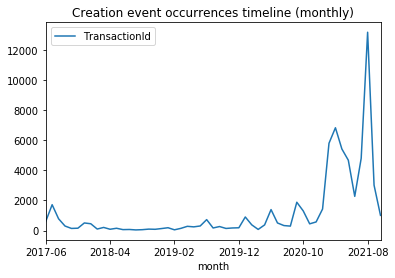

In [69]:
edge_df.loc[edge_df['EventType'] == "created", ['TransactionId', 'month']].groupby('month').count().plot()
plt.title("Creation event occurrences timeline (monthly)")